In [1]:
%matplotlib inline
import numpy as np
from numpy import genfromtxt  
from scipy.stats import norm
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

## Plotting functions

In [2]:
 def scatter(*data):
    '''
    scatter plot of 1dim data
    
    data list of 1 dim data
    '''
    
    plt.figure(figsize=(9,2))
    
    for x in data:
        plt.scatter(x, np.zeros((len(x), 1)))
        
    plt.yticks(())
    plt.show()
    
def plt_with_gaussians(data, mean, variance):
    '''
    scatter the data,
    and plot the given gaussian distributions
    
    data 1dim data to be scattered
    mean means of the normal distributions
    variance variances of the normal distributions
    '''
    
    plt.figure(figsize=(14, 7))
    
      # generate x values with min and max of the data
    x_values = np.linspace(data.min(), data.max(), 1001)
    # show the gaussians 
    for mu, sig in zip(mean, variance):
        plt.plot(x_values, gaussian(x_values, mu, sig))
        
    # scatter data points on x axis
    plt.scatter(data, np.zeros((len(data), 1)))
    
    plt.yticks(())
    plt.show()

## implementation of

- Gaussian distribution function
- Expectation Maximazation Algorithm
- Akaike Information Criterion

In [3]:
def gaussian(x, mu, sig):
    '''
    returns the likelihood of a point in a one dimensional gaussian with zero division protection
    
    x x value(s)
    mu mean of the gaussian
    sig variance of the gaussian 
    '''
    # if sigma is near zero, replace
    if np.isclose(sig, 0):
        sig = 1e-4
        
    return (1 / np.sqrt(2 * np.pi * sig)) * np.exp(-((x - mu) ** 2) / (2 * sig))

In [4]:
def any_nan(*xs):
    '''
    check for any NaN in numpy array and print if is True
    '''
    
    for i, x in enumerate(xs):
        if np.isnan(x).any():
            print(i, x)

In [5]:
def log_likelihood(data, mixing_coefficent, mean, variance):
    '''
    data 1dim data
    mixing_coefficents mixing coefficients / priors pi
    mean means of the gaussians mu 
    variance variances of the gaussians sigma
    
    returns the Log-Likelihood of a GMM
    '''
    
    # ensure data are flat ndarray
    if type(data) != np.ndarray or len(data.shape) != 1:
        data = np.array(data).flatten()
    
    # calculate log-likelihoods
    LL = 0 
        
    for pi, mu, sig in zip(mixing_coefficent, mean, variance):
        LL += pi * gaussian(data, mu, sig)
         
    return np.log(LL).sum()

In [6]:
def aic(data, mixing_coefficent, mean, variance):
    '''
    data 1dim data
    mixing_coefficents mixing coefficients / priors pi
    mean means of the gaussians mu 
    variance variances of the gaussians sigma
    
    returns the Akaike Information Criterion (aic) of a GMM 
    '''
    
    # ensure data are flat ndarray
    if type(data) != np.ndarray or len(data.shape) != 1:
        data = np.array(data).flatten()
    
    # calculate K (number of parameters)
    K = len(mean) * 3 - 1  # len of prior, mean and variance should be the same
    
    # aic
    return -2 * log_likelihood(data, mixing_coefficent, mean, variance) + 2 * K

In [7]:
def kmeans(data, k, n=10):
    '''
    kmeans clustering algorithm
    
    data 1d array data
    k number of clusters / means
    n times to repeat algorithm
    
    returns means
    '''
    
    # ensure data are 1d ndarray
    if type(data) != np.ndarray or len(data.shape) != 1:
        data = np.array(data).flatten()
    
    # init means randomly
    data_min, data_max = data.min(), data.max()
    mu = np.random.uniform(low=data_min, high=data_max, size=k)
     
    # loop through algorithm n times 
    for i in range(n):
        # augment data array k times, then calculate distances to means
        dist = np.abs(data * np.ones(k).reshape(-1, 1) - mu.reshape(-1, 1))
        # generate indices of which point belongs to which cluster
        distribution_assignment = dist.swapaxes(0, 1).argmin(axis=1)
        # recalculate means
        for j in range(k): 
            selection = data[distribution_assignment == j]
            if selection.shape[0] == 0:
                # if selection is empty rather set random value
                # instead of NaN which will mess with all future calculations
                mu[j] = np.random.uniform(low=data_min, high=data_max) 
            else:
                mu[j] = selection.mean()
              
    return mu 

In [8]:
def em(data, k=1, n=1, check_convergence=False, init='kmeans', outliers=0):
    '''
    1d expectation maximazation algorithm
    
    data 1d numpy array of data
    k Number of normal distributions
    n Number of em repetitions. If check_convergence is True, this is the max num of iterations.
    check_convergence Check with Log-Likelihood if the algorithm converges if is True.
    init [default='random', 'kmeans', model] How to initialize means and variances. If init is a dict with ['mu', 'sig', 'pi'] it will be initialized with these values.
    outliers Percentage of outliers [0; 100] (if > 0 remove percentage of outliers)
    
    returns mixing coefficients, means, variances
    '''
    
    # check parameters
    if k < 1 or n < 1:
        raise ValueError('k and n have to be > 1!')
    
    # ensure data are 1d ndarray
    if type(data) != np.ndarray or len(data.shape) != 1:
        data = np.array(data).flatten()
    
    # list of means and variances of the k normal distributions to be fitted
    min_data, max_data = data.min(), data.max() 
    
    if type(init) == dict:
        prior, mean, variance = init['pi'], init['mu'], init['sig']
    else:
        prior = np.full(k, 1 / k)  # assume priors (mixing coefficents) are equal
        variance = np.random.uniform(low=np.absolute(min_data / 2), high=np.absolute(max_data/2), size=k)

        if init == 'random':
            # init randomly between min and max points of data
            mean = np.random.uniform(low=min_data, high=max_data, size=k)
        elif init == 'kmeans':
            # use kmeans implementation for mean initialization
            mean = kmeans(data, k, 20)
        
        
    # previous LL to check for convergence if wanted
    prev_LL = 0
     
    # repeat algorithm n times
    for i in range(n):
        
        p_x_b = []
        
        # loop through each distribution j
        for j in range(k):
            # calcualate for each point the generative probability that it belongs to the distribution j
            # P(x | b)
            p_x_b.append(gaussian(data, mean[j], variance[j]))
            
        # convert to numpy array
        p_x_b = np.array(p_x_b)
         
        # calculate for each point the probability that it belongs to a distribution,
        # summing up to one ('colorings of the points')
        # P(b|x)
        p_wp = p_x_b * prior.reshape(-1, 1)
        bi =  p_wp / p_wp.sum(axis=0)
         
        # reestimate means
        mean = (bi * data).sum(axis=1) / bi.sum(axis=1)
        
        # reestimate variances
        for j in range(k):
            variance[j] = (bi[j] * (data - mean[j])**2).sum() / bi[j].sum()
            
        # reestimate priors
        distribution_assignment = bi.swapaxes(0, 1).argmax(axis=1)  # assign each data point to a specific distribution
        unique, counts = np.unique(distribution_assignment, return_counts=True)  # get unique values
        # counts array are in the correct order the counts of points that have the max likelihood
        # if no point belongs to one of the distributions replace this index with a zero in counts
        # compare with np.arange
        unique, counts = unique.tolist(), counts.tolist()
        for m in range(k):
            if m == len(unique) or unique[m] != m:
                unique.insert(m, -1)
                # insert small epsilon so that prior is not zero (division by zero)
                counts.insert(m, 1e-6)
                
                  
        # update mixing coefficents
        prior = np.array(counts) / data.shape[0]
        
        # check for convergence with log-likelihood if possible
        if check_convergence:
            LL = log_likelihood(data, prior, mean, variance)
            
            # if is close to prev LL, break the loop
            if np.isclose(prev_LL, LL):
                break
            
            prev_LL = LL
            
    
    # if outliers > 0 remove outliers with running this function again after removal of outliers with
    # mahalanobis distance from the previously calculated centers etc
    if outliers > 0:
        # list of all distributions with outliers removed
        new_data = []
        # loop through all distributions
        for j in range(k):
            # get data from distribution assignment
            # and use this specific selection since we donnot want to
            # treat points from other distributions as outliers
            # for this use distribution_assignment from last loop-through of em
            selection = data[distribution_assignment == j]
            # size of selection cannot be zero
            if selection.shape[0] != 0:
                # calculate 1d mahalanobis distance for distribution j (selection)
                std = selection.std()
                # donnot divide by zero
                if np.isclose(std, 0):
                    std = 1e-4
                
                dist_m = np.abs(selection - selection.mean()) / std
                # everthing over explicit threshold theta will be removed from selection
                theta = np.percentile(selection, 100 - outliers)
                 # add modified distribution (selection) to new_data
                new_data.append(selection[dist_m < theta])
            
        # re-run em algorithm after outlier removal
        init_args = {
            'pi': prior,
            'mu': mean,
            'sig': variance,
        } 
        
        prior, mean, variance = em(data=np.concatenate(tuple(new_data)),
                                    k=k, n=n, check_convergence=check_convergence, 
                                    outliers=0,
                                    init=init_args)
         
    # return means and variances
    return prior, mean, variance 

### load datasets

In [9]:
def load_iris():
    '''
    Returns a column of all petal lengths.
    '''
    X = genfromtxt("./data/iris.csv", delimiter=',', skip_header=1)
    X = X[:,2]
    X = X.reshape(-1, 1)
    return X

def load_bdp():
    '''
    Returns a column of systolic and diastolic blood pressure values.
    '''
    Z = genfromtxt("./data/bdp.csv", delimiter=',', skip_header=1)
    n = Z.shape[0]
    X = np.zeros(2*n)
    X[:n] = Z[:,2]
    X[n:] = Z[:,3]
    X = X.reshape(-1,1)
    return X

def sample(pi, mu, std, n):
    '''
    Returns a column of n values drawn from a normal mixture model.
    
    Parameter
        pi  k mixing coefficients
        mu  k means
        std k standard deviations
        n   number of data points
        
    Return
        n data points randomly sampled from specified mixture. 
    '''
    y = np.random.choice(len(pi), size=n, p=pi)
    x = np.zeros((n,1))
    for i, comp in enumerate(y):
        x[i] = norm.rvs(mu[comp], std[comp])
    return x


## Examples

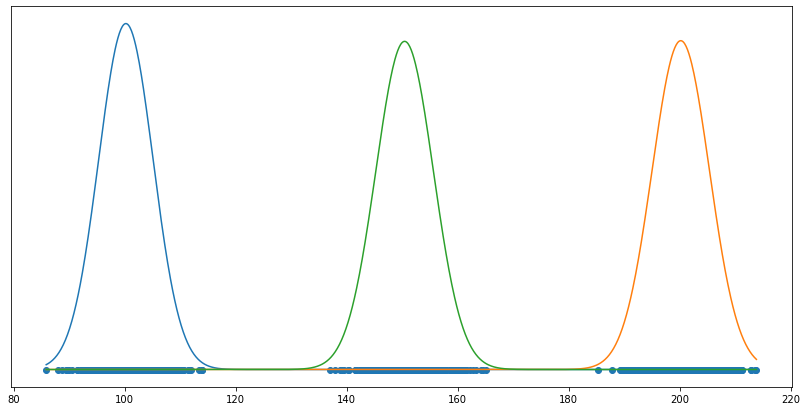

In [10]:
# generate n points from a mixture of fived normal distributions
n = 1000
mu = [100, 150, 200]
std = 5 * np.ones(len(mu))
pi = np.ones(len(mu))/ len(mu)
sample_x = sample(pi, mu, std, n)

priors, mu, sig = em(sample_x, 3, 10)
plt_with_gaussians(sample_x, mu, sig)

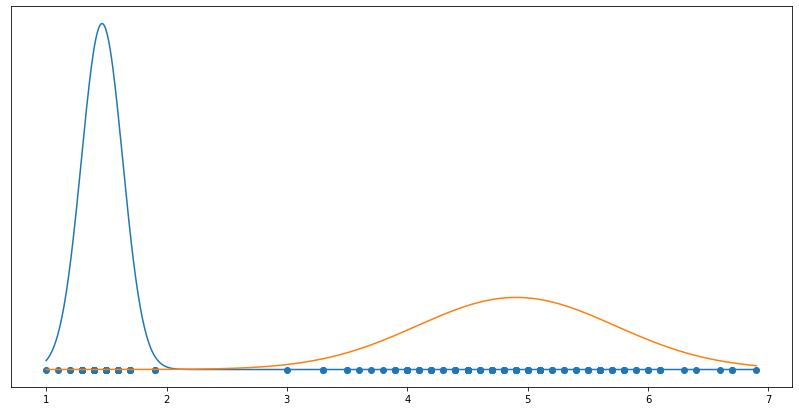

In [11]:
# load petal lengths of iris flowers
iris_x = load_iris()
priors, mu, sig = em(iris_x, 2, 10)
plt_with_gaussians(iris_x, mu, sig)

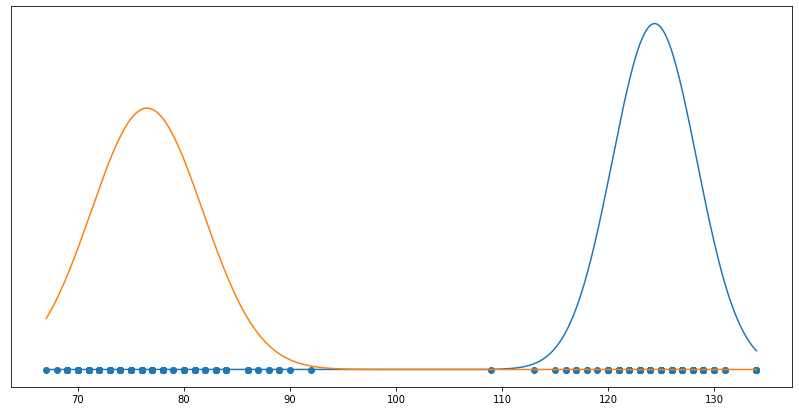

In [12]:
# load blood pressures
bdp_x = load_bdp()
priors, mu, sig = em(bdp_x, 2, 10)
plt_with_gaussians(bdp_x, mu, sig)

### compare my algorithm with sklearn's GMM

In [13]:
for j in range(1, 6):
    # sklearns EM / GMM
    gmm = GaussianMixture(n_components=j, init_params='kmeans', max_iter=100, reg_covar=1e-2)
    gmm.fit(sample_x)
     
    # my gmm 
    my_pi, my_mu, my_sig = em(sample_x, j, 10)
    sk_mu, sk_sig = sk_pi = gmm.means_.flatten(), gmm.covariances_.flatten()
    
    # print difference
    print(f'\n{j}')
    print(f'my mus = {my_mu}')
    print(f'sk mus = {sk_mu}')
    print(f'my sig = {my_sig}')
    print(f'sk sig = {sk_sig}')
    print(f'my aic = {aic(sample_x, my_pi, my_mu, my_sig)}')
    print(f'sk aic = {gmm.aic(sample_x)}')


1
my mus = [150.85281124]
sk mus = [150.85281124]
my sig = [1765.61895929]
sk sig = [1765.62895929]
my aic = 10318.133659448617
sk aic = 10318.133659464656

2
my mus = [200.26894747 124.41245059]
sk mus = [124.40624218 200.2683409 ]
my sig = [ 25.87202949 690.80646592]
sk sig = [690.42259844  25.89094587]
my aic = 9488.036027683742
sk aic = 9487.94845028074

3
my mus = [100.17916186 200.18514458 150.41446283]
sk mus = [150.41446283 100.17916186 200.18514458]
my sig = [24.11536784 26.69280746 26.80072601]
sk sig = [26.81072601 24.12536784 26.70280746]
my aic = 8297.854422033688
sk aic = 8297.854497402237

4
my mus = [203.83751636 200.18514457 100.17916186 150.41446283]
sk mus = [100.17916186 200.18514458 147.07082988 153.50071211]
my sig = [29.23358683 26.69280741 24.11536784 26.80072601]
sk sig = [24.12536784 26.70280746 13.23266731 19.49936358]
my aic = 8303.854420019175
sk aic = 8302.873643337649

5
my mus = [150.41446281 100.17916187 157.02099122  97.72082657 200.18514458]
sk mus =

# conduct experiment of the assignment

In [14]:
# conduct experiment
def select_gmm(data, log='v', **emargs):
    '''
    selects the best model according to aic for k = {1..15}
    
    data 1dim data array
    log [default='v(erbose)', 'vp (verbose-plot)', n(one)]
    '''
    
    # best model and aic
    best = None
    
    for k in range(1, 16):
        # generate gmm
        pi, mu, sig = em(data, k, **emargs)
        
        # calc aic
        t_aic = aic(data, pi, mu, sig)
        
        # create model dict
        model = {
            'k': k,
            'pi': pi, 
            'mu': mu, 
            'sig': sig, 
            'aic': t_aic
        }
        
        # print model if is verbose
        if log == 'v' or log == 'vp': 
            print(k, t_aic)
        if log == 'vp':
            plt_with_gaussians(data, mu, sig)
        
        # compare current looping model to best model
        if best == None or t_aic < best['aic']:
            best = model
            
            if log == 'v' or log == 'vp':
                print('This is the new best model according to aic (above)!')
        
            
    return best
        
def sel_plt(data, **emargs):
    '''
    select and plot best model according to aic
    
    data 1dim data array
    '''
    
    model = select_gmm(data, 'vp', **emargs)
    print('best model:')
    plt_with_gaussians(data, model['mu'], model['sig'])